In [70]:
import os
from datetime import datetime
from typing import Optional

from netCDF4 import Dataset
import spacepy.pycdf
import h5py
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from scipy.signal import savgol_filter

import pyDMSP

plt.rcParams['figure.figsize'] = [20, 5]  # 设置图形的默认尺寸为20x5英寸

In [71]:
ssies3_fp = r"G:\0_postgraduate\DMSP\data\2014\f16\ssies3\dmsp-f16_ssies-3_thermal-plasma_201401010137_v01.cdf"
ssies3 = pyDMSP.CDFFile(ssies3_fp, is_f17=False)
ssies3_data = ssies3.ssies3_data()

In [72]:
vx_set_nan = ssies3.vx_set_nan()
vy_set_nan = ssies3.v_yz_set_nan(v_str='vy')
vz_set_nan = ssies3.v_yz_set_nan(v_str='vz')

In [73]:
window_size = 10  # 这表示窗口包含10个数据点，即10秒
# 计算滑动平均
vx_set_nan['vx_smooth'] = vx_set_nan['vx'].rolling(window=window_size, center=True, min_periods=1).mean()

(<Axes: >, <Axes: >)

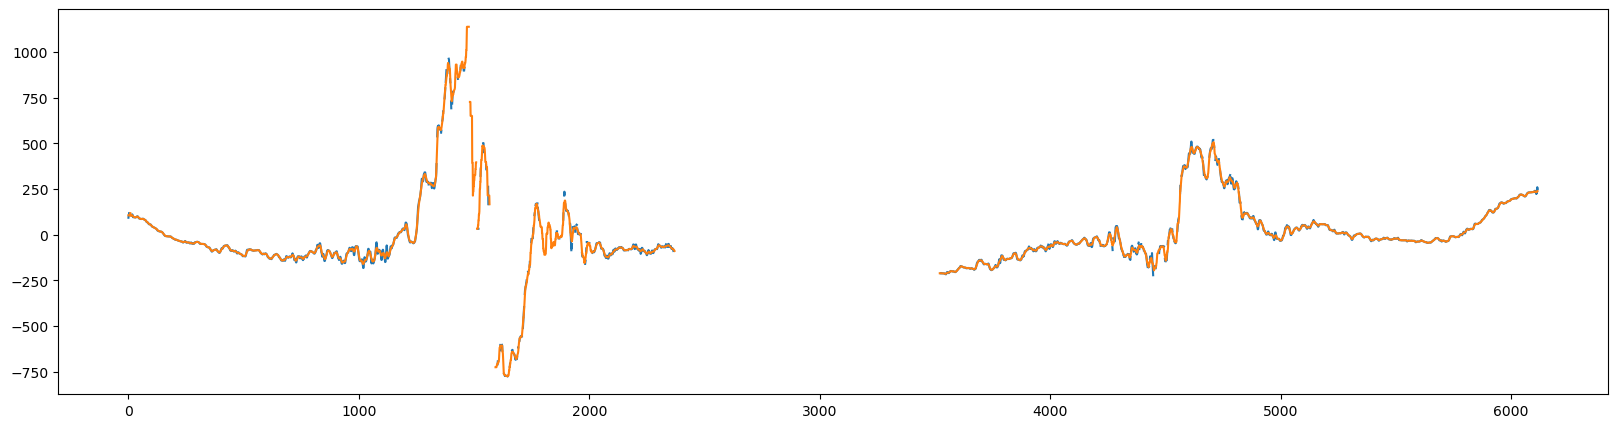

In [74]:
vx_set_nan['vx'].plot(),vx_set_nan['vx_smooth'].plot()

(<Axes: >, <Axes: >)

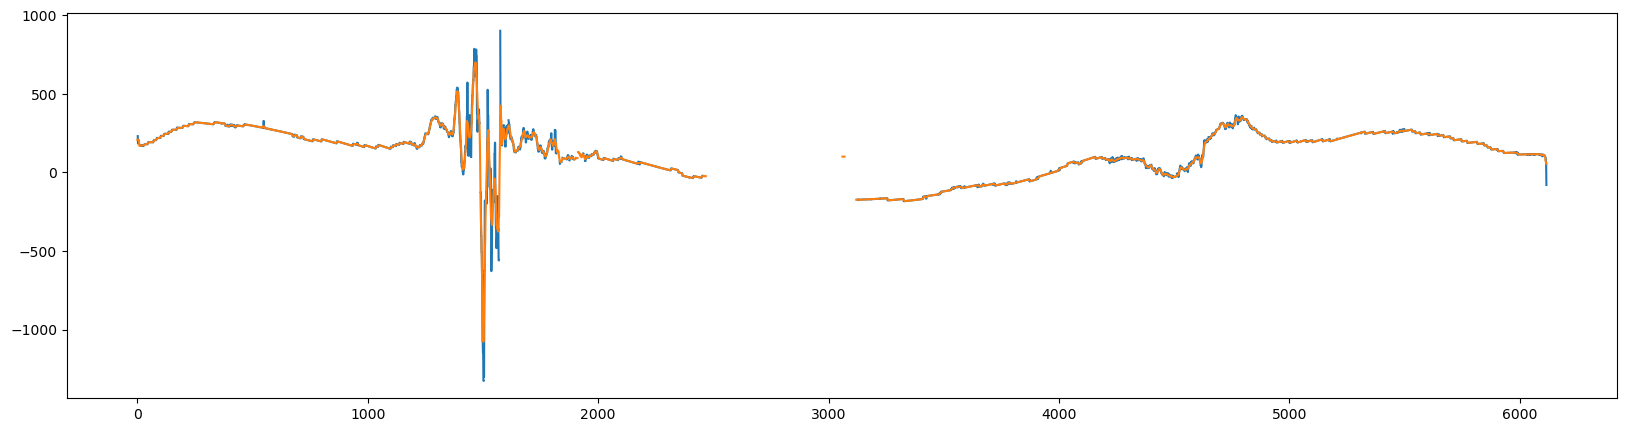

In [75]:
vy_set_nan['vy_smooth'] = vy_set_nan['vy'].rolling(window=window_size, center=True, min_periods=1).mean()
vy_set_nan['vy'].plot(),vy_set_nan['vy_smooth'].plot()

In [76]:
ssm_fp = r"G:\0_postgraduate\DMSP\data\2014\f16\ssm\dmsp-f16_ssm_magnetometer_20140101_v1.0.4.cdf"
ssm = pyDMSP.CDFFile(ssm_fp,is_f17=False)
ssm_data = ssm.ssm_data()

(<Axes: >, <Axes: >)

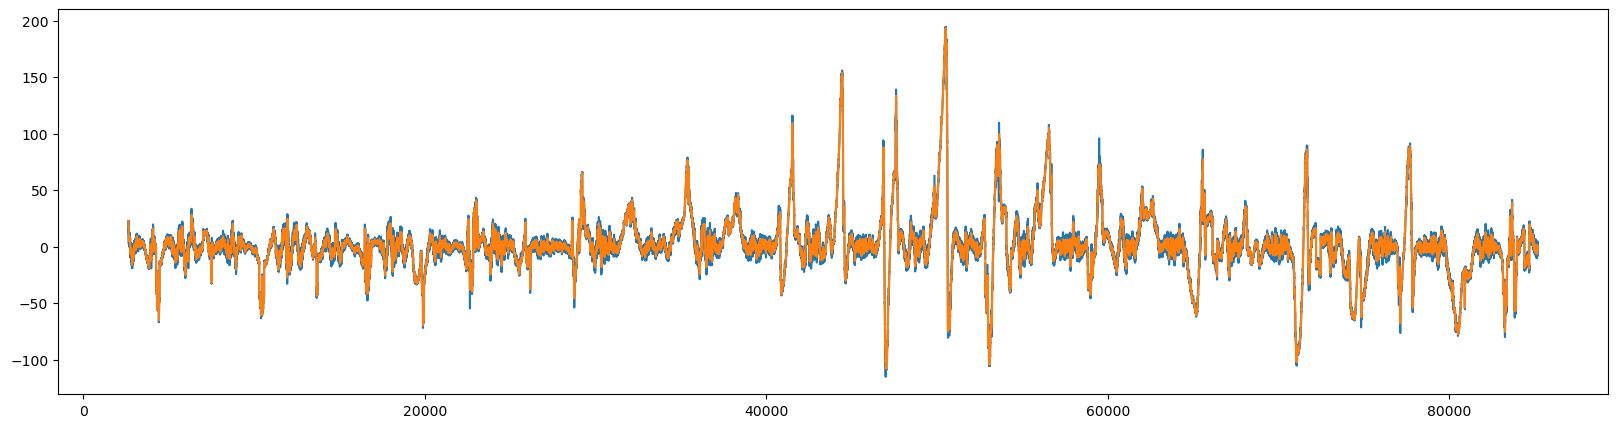

In [77]:
window_size = 10
ssm_data['DELTA_B_SC_x_mov_ave'] = ssm_data['DELTA_B_SC_x'].rolling(window=window_size,center=True,min_periods=1).mean()
ssm_data['DELTA_B_SC_x'].plot(),ssm_data['DELTA_B_SC_x_mov_ave'].plot()

In [78]:
ssies3_data_SC, ssm_data_clip = pyDMSP.data_for_draw(ssies3_fp,ssm_fp,is_f17=False)

In [79]:
ssies3_data_SC['V_SC_x_mov_ave'] = ssies3_data_SC['V_SC_x'].rolling(window=window_size,center=True,min_periods=1).mean()
ssies3_data_SC['V_SC_y_mov_ave'] = ssies3_data_SC['V_SC_y'].rolling(window=window_size,center=True,min_periods=1).mean()
ssies3_data_SC['V_SC_z_mov_ave'] = ssies3_data_SC['V_SC_z'].rolling(window=window_size,center=True,min_periods=1).mean()

In [80]:
ssm_data_clip['DELTA_B_SC_x_mov_ave'] = ssm_data_clip['DELTA_B_SC_x'].rolling(window=window_size,center=True,min_periods=1).mean()
ssm_data_clip['DELTA_B_SC_y_mov_ave'] = ssm_data_clip['DELTA_B_SC_y'].rolling(window=window_size,center=True,min_periods=1).mean()
ssm_data_clip['DELTA_B_SC_z_mov_ave'] = ssm_data_clip['DELTA_B_SC_z'].rolling(window=window_size,center=True,min_periods=1).mean()

In [81]:
ssies3_data_SC['V_SC_x_fillna']= ssies3_data_SC['V_SC_x'].fillna(method='ffill').fillna(method='bfill')
ssies3_data_SC['V_SC_y_fillna']= ssies3_data_SC['V_SC_y'].fillna(method='ffill').fillna(method='bfill')
ssies3_data_SC['V_SC_z_fillna']= ssies3_data_SC['V_SC_z'].fillna(method='ffill').fillna(method='bfill')

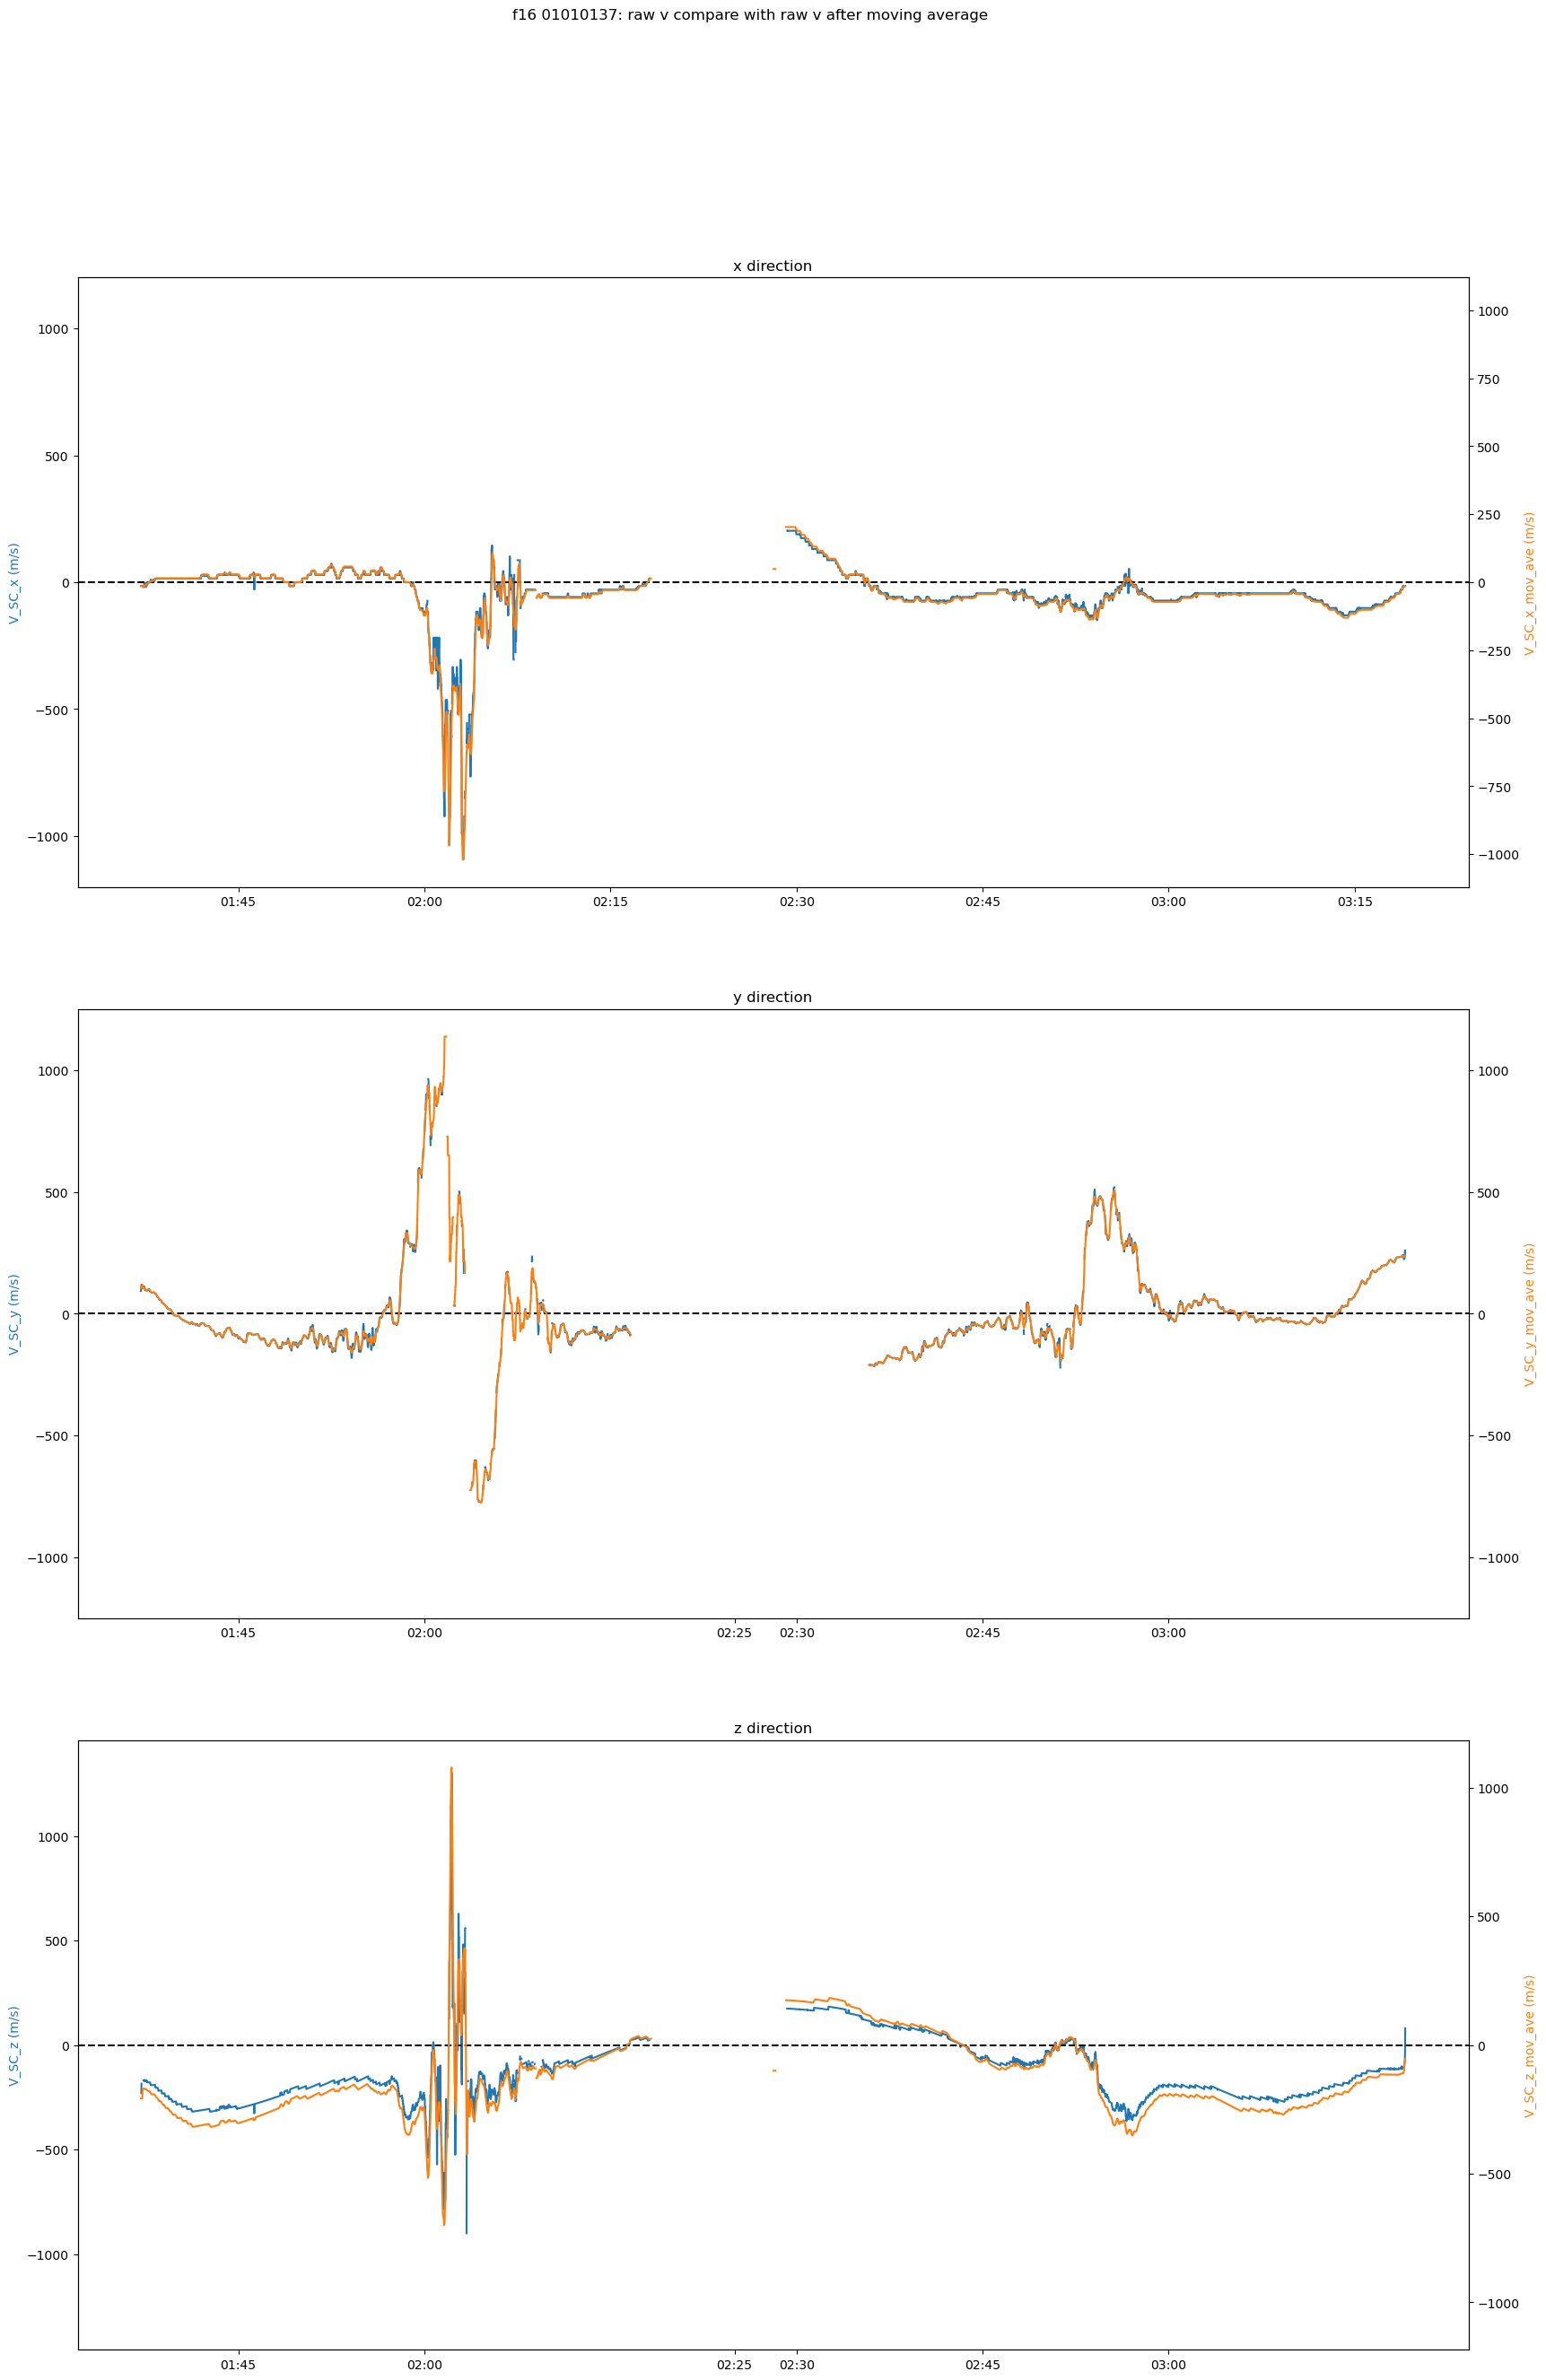

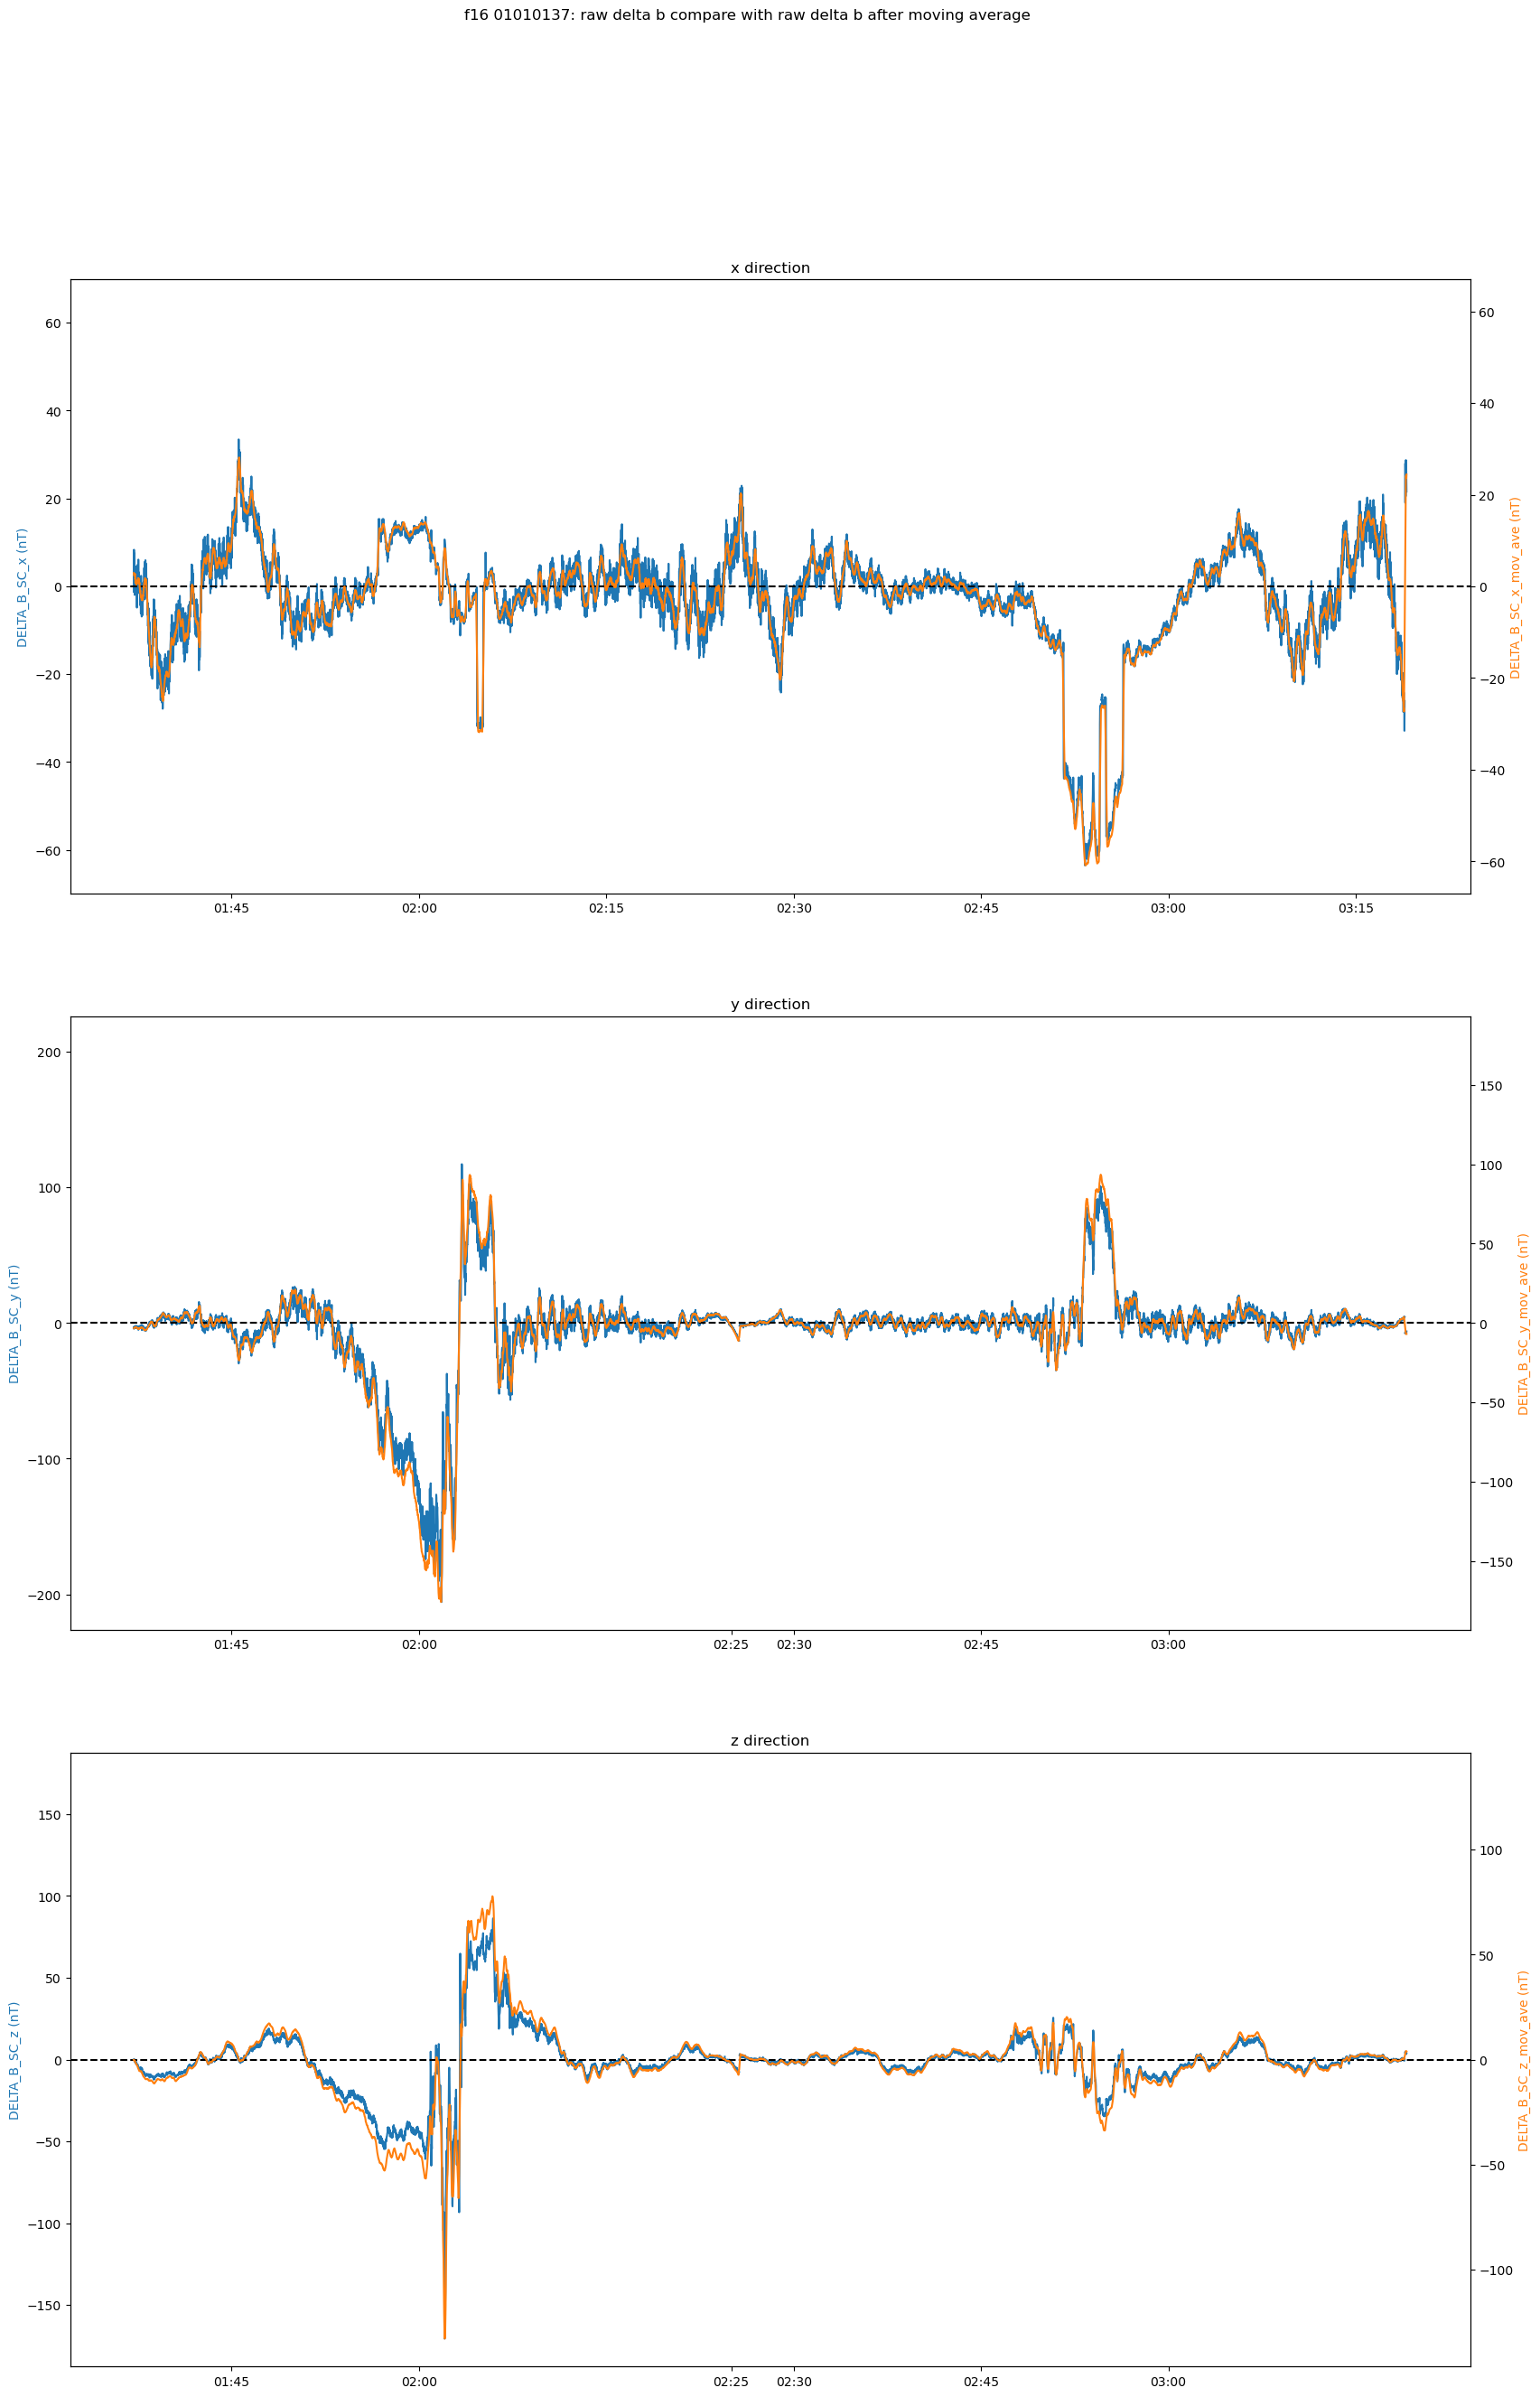

In [82]:
ssies3_v_strs = ['V_SC_x', 'V_SC_y', 'V_SC_z']
ssies3_v_strs_mov_ave = ['V_SC_x_mov_ave', 'V_SC_y_mov_ave', 'V_SC_z_mov_ave']
ssm_v_strs = ['DELTA_B_SC_x', 'DELTA_B_SC_y', 'DELTA_B_SC_z']
ssm_v_strs_mov_ave = ['DELTA_B_SC_x_mov_ave', 'DELTA_B_SC_y_mov_ave', 'DELTA_B_SC_z_mov_ave']

fig = pyDMSP.draw_ssies3_ssm(ssies3_data_SC, ssies3_data_SC, ssies3_v_strs, ssies3_v_strs_mov_ave,
                             'm/s', 'm/s', dhm='01010137', title_part='raw v compare with raw v after moving average',satellite='16')

fig = pyDMSP.draw_ssies3_ssm(ssm_data_clip, ssm_data_clip, ssm_v_strs, ssm_v_strs_mov_ave,
                             'nT', 'nT', dhm='01010137', title_part='raw delta b compare with raw delta b after moving average',satellite='16')

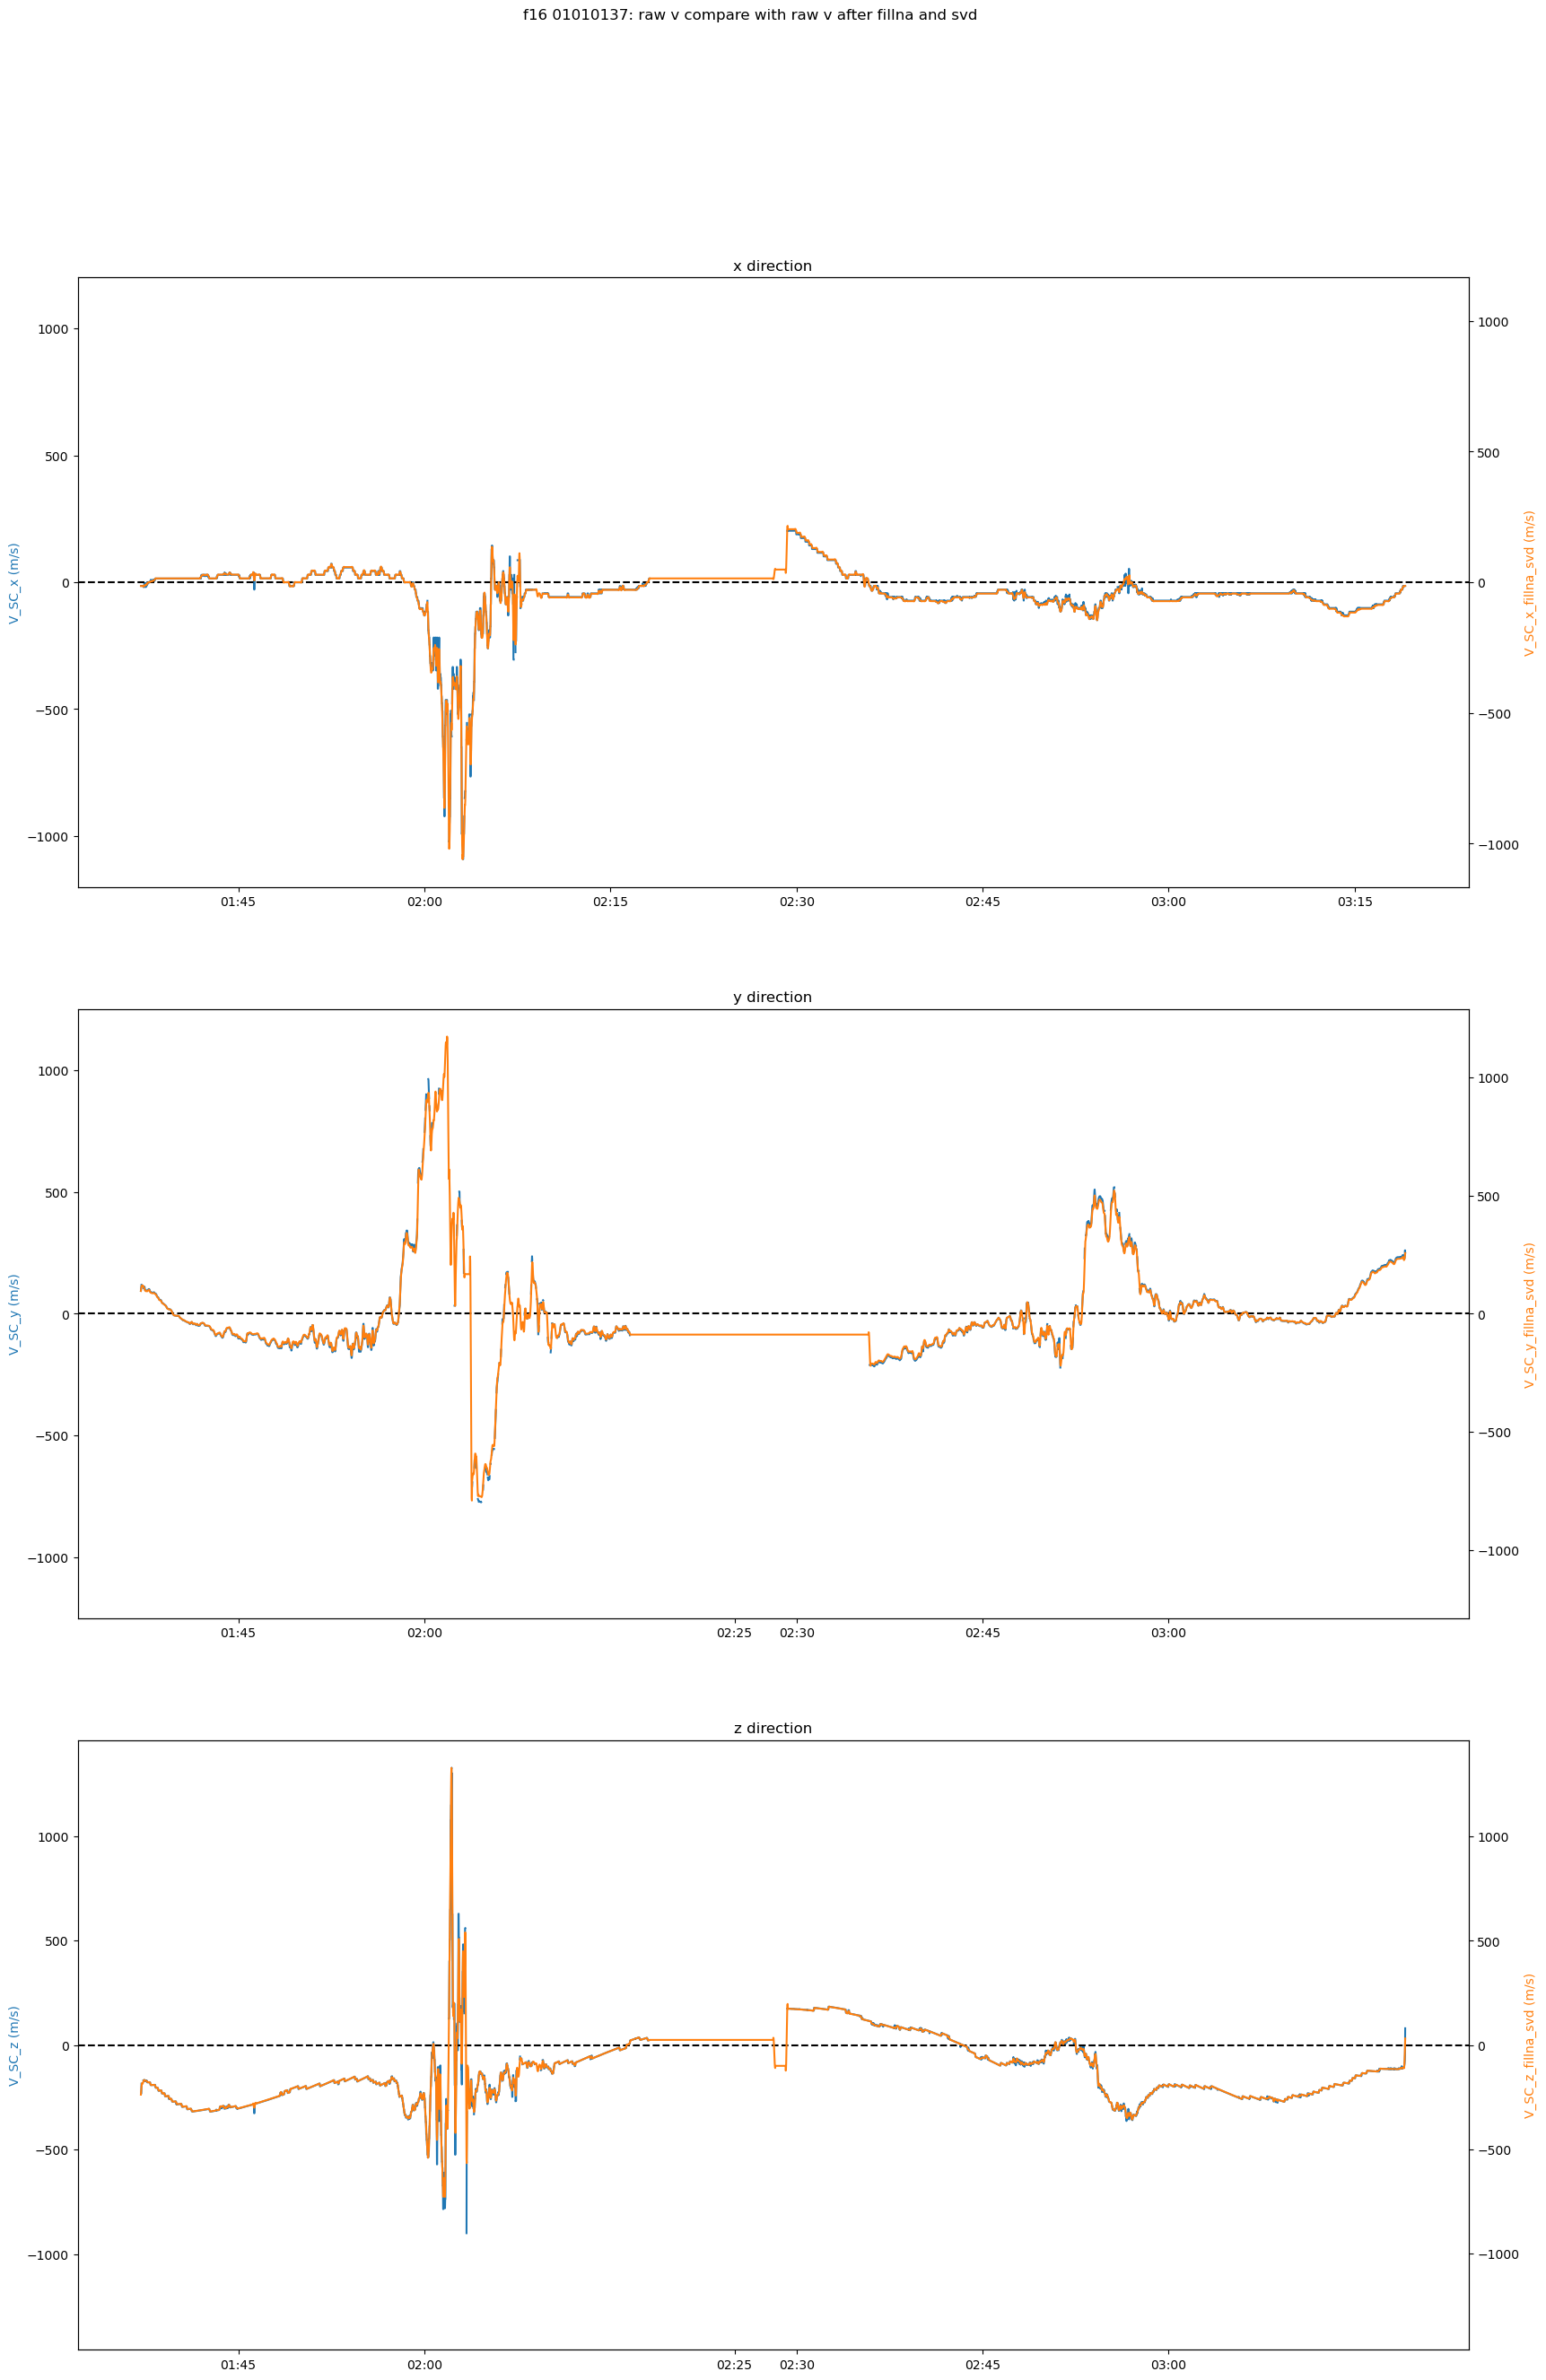

In [83]:
ssies3_data_SC['V_SC_x_fillna_svd'] = savgol_filter(ssies3_data_SC['V_SC_x_fillna'],window_length=11,polyorder=2)
ssies3_data_SC['V_SC_y_fillna_svd'] = savgol_filter(ssies3_data_SC['V_SC_y_fillna'],window_length=11,polyorder=2)
ssies3_data_SC['V_SC_z_fillna_svd'] = savgol_filter(ssies3_data_SC['V_SC_z_fillna'],window_length=11,polyorder=2)

ssies3_v_strs_fillna_svd = ['V_SC_x_fillna_svd', 'V_SC_y_fillna_svd', 'V_SC_z_fillna_svd']

fig = pyDMSP.draw_ssies3_ssm(ssies3_data_SC, ssies3_data_SC, ssies3_v_strs, ssies3_v_strs_fillna_svd,
                             'm/s', 'm/s', dhm='01010137', title_part='raw v compare with raw v after fillna and svd',satellite='16')

In [86]:
from scipy.signal import butter, filtfilt

vx_bdf = pyDMSP.BandPassFilter(ssies3_data_SC['V_SC_x_fillna'],ssies3_data_SC['Epoch'],'01010137')

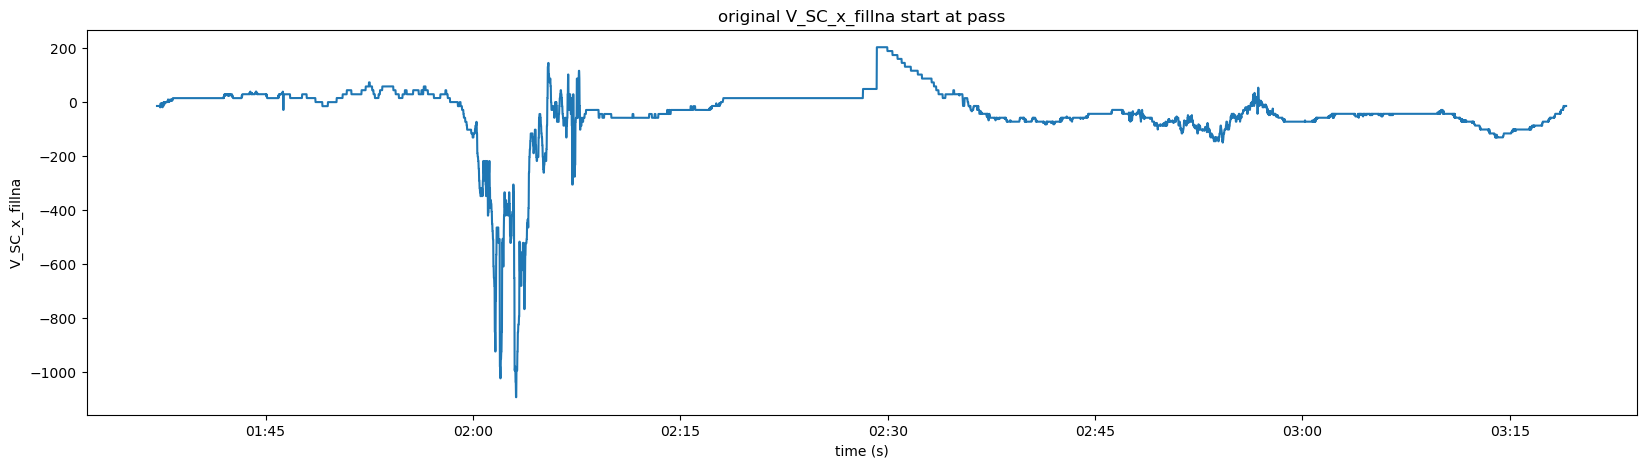

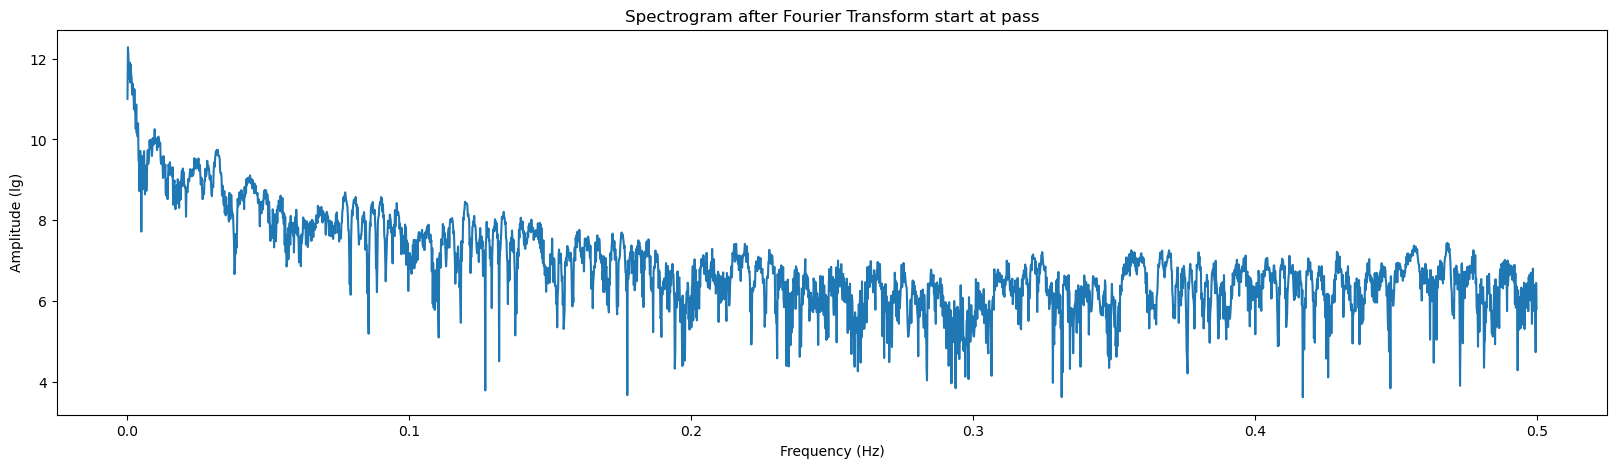

In [92]:
fig = vx_bdf.draw_original_signal()
fig = vx_bdf.draw_frequency_amplitude(is_log=True)

In [99]:
# 设定滤波器参数
fs = 1  # 采样频率
cutoff = 0.001  # 截止频率（Hz）
nyq = 0.5 * fs  # 奈奎斯特频率
normal_cutoff = cutoff / nyq  # 归一化截止频率

# 设计Butterworth低通滤波器
b, a = butter(N=5, Wn=normal_cutoff, btype='low', analog=False)
v_sc_x_fillna_filter = filtfilt(b, a, ssies3_data_SC['V_SC_x_fillna'])

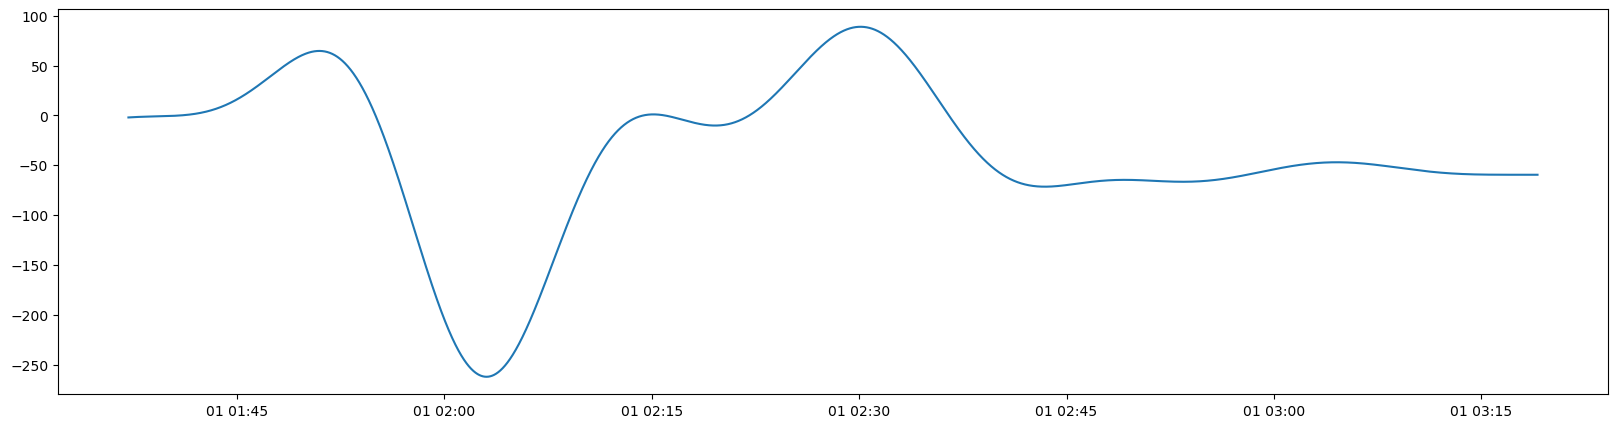

In [100]:
plt.plot(ssies3_data_SC['Epoch'],v_sc_x_fillna_filter)